# Dependencies

In [2]:
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

import datetime as dt
import scipy.stats as sts
import scipy.ndimage as ndimage

from math import isnan
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from Resources.config import app_token


# Additional Depedencies which requires updating your environment

In [3]:
import descartes
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
%matplotlib inline

# Import Resources

In [4]:
## Source: Crimes - 2001 to present
## https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2
url_crime_data = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
date_filter="$WHERE=DATE BETWEEN '2014-01-01' AND '2018-12-31'"
crime_records_limit = 2000000
url_crime_data_with_filter = f"{url_crime_data}?{date_filter}&$limit={crime_records_limit}&$$app_token={app_token}"
crime_data_json = requests.get(url_crime_data_with_filter).json()
crime_data_df = pd.DataFrame.from_records(crime_data_json)
crime=crime_data_df

crime = crime.rename(columns={"date": "Date"
                           , "primary_type": "Primary Type"
                           , "description": "Description"
                           , "community_area": "Community Area"
                           , "longitude": "Longitude"
                           , "latitude": "Latitude"
                           , "id": "ID"
                          })
crime['Community Area'] = pd.to_numeric(crime['Community Area'],downcast='integer')
crime['Longitude'] = pd.to_numeric(crime['Longitude'],downcast='integer')
crime['Latitude'] = pd.to_numeric(crime['Latitude'],downcast='integer')

In [31]:
# Street Light Data Source from 2014-2018
street_light_reports = "Resources/Service_Requests_Street_Lights.csv" 

# Read Street Light Data and store into Pandas data frame, add ability to read special chrarters
street_light_reports_pd = pd.read_csv(street_light_reports,encoding= "ISO-8859-1")
# street_light_reports_pd = street_light_reports_pd.rename(columns={"ÈÀCreation Date": "Creation Date"})
                                
street=street_light_reports_pd

street = street.rename(columns={"ÈÀCreation Date": "Creation Date"
                                ,"Creation Date": "Creation Date"
                           , "status": "Status"
                           , "completion_date": "Completion Date"
                           , "service_request_number": "Service Request Number"
                           , "type_of_service_request": "Type of Service Request"
                           , "community_area": "Community Area"
                                , "longitude": "Longitude"
                                , "latitude": "Latitude"
                          })

street['Longitude'] = pd.to_numeric(street['Longitude'],downcast='integer')
street['Latitude'] = pd.to_numeric(street['Latitude'],downcast='integer')

In [20]:
# Community Area Names Data Source 
community_area_names = "Resources/CommAreas_20200108.csv" 

# Read Community Area Names Data and store into Pandas data frame, add ability to read special characters
community_area_names_pd = pd.read_csv(community_area_names,encoding= "ISO-8859-1")
comm=community_area_names_pd

comm = comm.rename(columns={"area_numbe": "AREA_NUMBE"
                           , "community": "COMMUNITY"
                          })

In [21]:
# Pop Census Data Source 
pop_census_data = "Resources/Pop-Census-Data-by-Chicago-Community-Area-2017.csv" 

# Read Pop Census Data by Chicago Community and store into Pandas data frame.
pop_census_data_pd = pd.read_csv(pop_census_data)
pop=pop_census_data_pd
pop['Community'] = pop['Community'].str.upper() 
pop2=pop[['Total Population','Community']]
pop2.sort_values(by='Total Population', ascending=False)

,Total Population,Community
0,102584,LAKE VIEW
1,97604,AUSTIN
2,96466,NEAR NORTH SIDE
3,84660,WEST TOWN
4,78037,BELMONT CRAGIN
...,...,...
72,7033,AVALON PARK
73,6565,RIVERDALE
74,5181,OAKLAND
75,3220,FULLER PARK


# Data cleanup

In [32]:
#Data Cleanup - Rename Creation Date Column Because it Has Unnecessary Charaters in the CSV Field
street_light_reports_pd = street_light_reports_pd.rename(columns={'ÈÀCreation Date': 'Creation Date'})

# Add a Column for Year, Month, Day in Street Light Outage Data 
street_light_reports_pd['Year'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).year
street_light_reports_pd['Month'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).month
street_light_reports_pd['Day'] = pd.DatetimeIndex(street_light_reports_pd['Creation Date']).day

#Filter Street Light data for everything greater than 2013 and less than 2018
street_light_reports_pd = street_light_reports_pd.loc[(street_light_reports_pd['Year']>2013) & (street_light_reports_pd['Year']<2019)]
street_light_reports_pd

## Delete extra columns
#del street_light_reports_pd["Ward", "Police District"]
street_light_reports_pd = street_light_reports_pd.drop(["Ward", "Police District"], axis=1)
street_light_reports_pd.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Latitude,Longitude,Location,Year,Month,Day
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,41.899195,-87.706674,"(41.899195401337, -87.706674456727)",2017,8,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,41.682806,-87.630013,"(41.682805663082, -87.630013185779)",2017,8,3
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,41.702516,-87.630794,"(41.702515706043, -87.630793923998)",2017,8,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,41.865861,-87.659093,"(41.865861460198, -87.659093452162)",2017,8,3
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,41.910115,-87.706960,"(41.91011532918, -87.706960465932)",2017,8,3


CLEANING AND FILTERING CRIME DATA

In [12]:
#remove the records with zero as the community area
crime=crime.loc[crime['Community Area']!=0]

#creating new columns for Year, Month, and Day
crime['Year'] = pd.DatetimeIndex(crime['Date']).year
crime['Month'] = pd.DatetimeIndex(crime['Date']).month
crime['Day'] = pd.DatetimeIndex(crime['Date']).day

#filtering data for everything greater than 2013 and less than 2019
crime=crime.loc[(crime['Year']>2013) & (crime['Year']<2019)]

CLEANING AND FILTERING 311 - STREET LIGHT OUTAGES DATA

In [26]:
#add a year column
street['Year'] = pd.DatetimeIndex(street['Creation Date']).year
street['Month'] = pd.DatetimeIndex(street['Creation Date']).month
street['Day'] = pd.DatetimeIndex(street['Creation Date']).day
street=street.loc[(street['Year']>2013) & (street['Year']<2019)]

#Filtering out null and zero values
street_nonull=street.dropna(subset=['Community Area'])
street_nozero=street_nonull.loc[street_nonull['Community Area']!=0]

MERGING CRIME AND COMMUNITY AREAS DATA

In [27]:
#merge the crime data with the community areas data
crime_comm = pd.merge(crime, comm, left_on="Community Area", right_on='AREA_NUMBE', how="left")


MERGING 311-STREET LIGHT OURAGES AND COMMUNITY AREAS DATA

In [28]:
#merge the street data with the community areas data
street_comm = pd.merge(street_nozero, comm, left_on="Community Area", right_on='AREA_NUMBE', how="left")

## Question 1 - Which Chicago neighborhoods have the most street light outages reported between 2014-2018?

In [33]:
#Create Community Area Count Variable
community_area_counts = street_light_reports_pd.groupby(["Community Area"])["Creation Date"].nunique()

#Display Summary of Community Area Counts in Data Frame
community_area_summary_table = pd.DataFrame({"Total Street Light Outage Reportings": community_area_counts})
community_area_summary_table

,Total Street Light Outage Reportings
Community Area,
0.0,192
1.0,323
2.0,637
3.0,363
4.0,476
...,...
73.0,937
74.0,520
75.0,817


In [34]:
#Display Summary of Community Area Names and Corresposonding Number in Data Frame
community_area_names=community_area_names_pd[['COMMUNITY','AREA_NUMBE']]
community_area_names

,COMMUNITY,AREA_NUMBE
0,DOUGLAS,35
1,OAKLAND,36
2,FULLER PARK,37
3,GRAND BOULEVARD,38
4,KENWOOD,39
...,...,...
72,MOUNT GREENWOOD,74
73,MORGAN PARK,75
74,OHARE,76
75,EDGEWATER,77


In [35]:
# Merge Dataframes to get Street Light Outage Reports and Community Names in One Dataframe
community_data_merge = pd.merge(community_area_summary_table,community_area_names,left_on='Community Area', right_on='AREA_NUMBE', how="right")

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort = community_data_merge.sort_values(by='Total Street Light Outage Reportings', ascending=False)

# Display the Top 10 Neighborhoods With Most Street Light Outages 2014 to 2018
community_sort.head(10)

,Total Street Light Outage Reportings,COMMUNITY,AREA_NUMBE
24,1207,AUSTIN,25
48,1092,ROSELAND,49
23,1092,WEST TOWN,24
69,1085,ASHBURN,70
70,1071,AUBURN GRESHAM,71
27,977,NEAR WEST SIDE,28
65,957,CHICAGO LAWN,66
22,951,HUMBOLDT PARK,23
72,937,WASHINGTON HEIGHTS,73
42,924,SOUTH SHORE,43


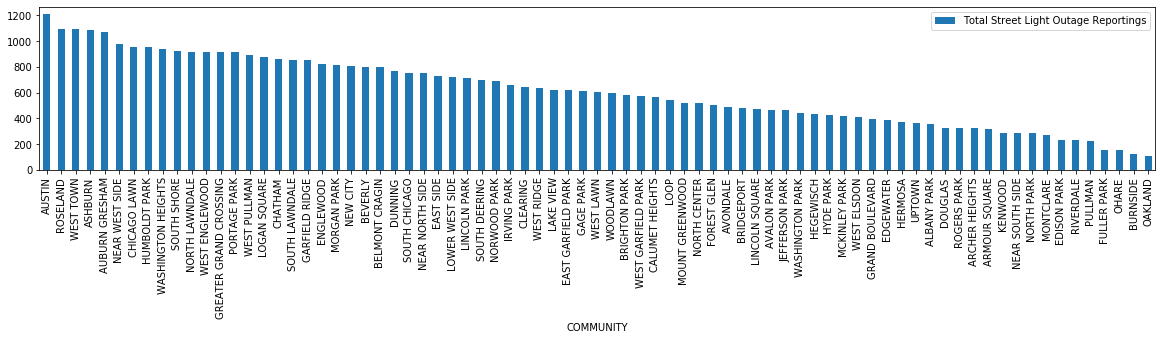

In [36]:
#Display Bar Chart to compare community area street light outages between 2014-2018
community_chart = community_sort.plot.bar(y='Total Street Light Outage Reportings', x='COMMUNITY', rot=90, figsize=(20,3))
plt.savefig("Charts/Street_Light_Outage_by_Community")

In [37]:
# Filter Street Light Outage Totals by Year 
year_2014 = street_light_reports_pd[street_light_reports_pd['Year']==2014]
year_2015 = street_light_reports_pd[street_light_reports_pd['Year']==2015]
year_2016 = street_light_reports_pd[street_light_reports_pd['Year']==2016]
year_2017 = street_light_reports_pd[street_light_reports_pd['Year']==2017]
year_2018 = street_light_reports_pd[street_light_reports_pd['Year']==2018]

In [38]:
#Filter Street Light Counts by 2014 
counts_by_year_2014 = year_2014.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2014 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2014_summary_table = pd.DataFrame({ "# of Outages in 2014": counts_by_year_2014})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2014 = counts_by_year_2014_summary_table.sort_values(by='# of Outages in 2014', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2014
community_sort_2014.head(5)

,,# of Outages in 2014
Community Area,Year,
49.0,2014,255
25.0,2014,254
71.0,2014,237
73.0,2014,222
15.0,2014,219


In [39]:
#Filter Street Light Counts by 2015 
counts_by_year_2015 = year_2015.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2015 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2015_summary_table = pd.DataFrame({"# of Outages in 2015": counts_by_year_2015})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2015 = counts_by_year_2015_summary_table.sort_values(by='# of Outages in 2015', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2015
community_sort_2015.head(5)

,,# of Outages in 2015
Community Area,Year,
25.0,2015,240
70.0,2015,236
49.0,2015,223
71.0,2015,214
43.0,2015,210


In [40]:
#Filter Street Light Counts by 2016 
counts_by_year_2016 = year_2016.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2014 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2016_summary_table = pd.DataFrame({"# of Outages in 2016": counts_by_year_2016})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2016 = counts_by_year_2016_summary_table.sort_values(by='# of Outages in 2016', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2016
community_sort_2016.head(5)

,,# of Outages in 2016
Community Area,Year,
24.0,2016,243
25.0,2016,228
71.0,2016,224
70.0,2016,221
49.0,2016,220


In [41]:
#Filter Street Light Counts by 2017 
counts_by_year_2017 = year_2017.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2017 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2017_summary_table = pd.DataFrame({"# of Outages in 2017": counts_by_year_2017})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2017 = counts_by_year_2017_summary_table.sort_values(by='# of Outages in 2017', ascending=False)

# Display the Top 5 Neighborhoods With Most Street Light Outages in 2017
community_sort_2017.head(5)

,,# of Outages in 2017
Community Area,Year,
25.0,2017,252
24.0,2017,228
70.0,2017,223
23.0,2017,205
30.0,2017,198


In [42]:
#Filter Street Light Counts by 2018
counts_by_year_2018 = year_2018.groupby(["Community Area","Year"])["Creation Date"].nunique()

#Display 2018 Summary of Street Light Outages by Year in Data Frame
counts_by_year_2018_summary_table = pd.DataFrame({"# of Outages in 2018": counts_by_year_2018})

#Sort Merged Dataframe by Highest Street Light Outages to Find Community With Highest Street Outages
community_sort_2018 = counts_by_year_2018_summary_table.sort_values(by='# of Outages in 2018', ascending=False)

# Display the Top 10 Neighborhoods With Most Street Light Outages in 2018
community_sort_2018.head(5)

,,# of Outages in 2018
Community Area,Year,
25.0,2018,233
24.0,2018,221
49.0,2018,204
71.0,2018,203
28.0,2018,201


## Question 2 - What address has the most street light outage reports? Which year had the most street light outage reports?

## Question 3 - Average time it takes for outages to get fixed per neighborhood?

In [43]:
## Join 2 tables to display community names.
service_requests_by_community = pd.merge(street_light_reports_pd, community_area_names_pd, left_on='Community Area', right_on='AREA_NUMBE', how='left')
## Drop extra column
service_requests_by_community = service_requests_by_community.drop(["Latitude","Longitude","Location","AREA_NUMBE","the_geom","PERIMETER","AREA","COMAREA_","COMAREA_ID","AREA_NUM_1","SHAPE_AREA","SHAPE_LEN"], axis=1)
## Calculate service requests resolution time after setting completion_date to current date if N/A
service_requests_by_community['Resolution Time(days)'] = (pd.to_datetime(service_requests_by_community['Completion Date'].fillna(pd.datetime.now().date())) - pd.to_datetime(service_requests_by_community['Creation Date'])).dt.days
service_requests_by_community.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Year,Month,Day,COMMUNITY,Resolution Time(days)
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,2017,8,2,HUMBOLDT PARK,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,2017,8,3,WEST PULLMAN,1
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,2017,8,2,ROSELAND,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,2017,8,3,NEAR WEST SIDE,1
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,2017,8,3,HUMBOLDT PARK,1


In [44]:
## Filter out rows where community_area = 0 OR service_request_number is duplicate 
service_requests_by_community = service_requests_by_community.loc[(service_requests_by_community['Community Area']!=0)]
service_requests_by_community = service_requests_by_community.drop_duplicates(subset="Service Request Number")
service_requests_by_community.head()

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,Street Address,ZIP Code,X Coordinate,Y Coordinate,Community Area,Year,Month,Day,COMMUNITY,Resolution Time(days)
0,8/2/2017,Completed,8/4/2017,17-05118301,Street Lights - All/Out,3200 W AUGUSTA BLVD,60651.0,1154852.812,1906479.787,23.0,2017,8,2,HUMBOLDT PARK,2
1,8/3/2017,Completed,8/4/2017,17-05149048,Street Lights - All/Out,11633 S PRINCETON AVE,60628.0,1176368.398,1827790.516,53.0,2017,8,3,WEST PULLMAN,1
2,8/2/2017,Completed,8/4/2017,17-05136485,Street Lights - All/Out,300 W 105TH PL,60628.0,1176096.554,1834970.868,49.0,2017,8,2,ROSELAND,2
3,8/3/2017,Completed,8/4/2017,17-05143874,Street Lights - All/Out,1250 S THROOP ST,60608.0,1167901.851,1894431.139,28.0,2017,8,3,NEAR WEST SIDE,1
4,8/3/2017,Completed,8/4/2017,17-05149056,Street Lights - All/Out,1600 N KEDZIE AVE,60647.0,1154745.892,1910458.441,23.0,2017,8,3,HUMBOLDT PARK,1


In [45]:
service_requests_by_community_average_time = service_requests_by_community.groupby(["COMMUNITY","Year"])["Resolution Time(days)"].mean()
service_requests_by_community_average_time.sort_values(ascending=False)
service_requests_by_community_average_time = pd.DataFrame(service_requests_by_community_average_time).reset_index()
service_requests_by_community_average_time

,COMMUNITY,Year,Resolution Time(days)
0,ALBANY PARK,2014,3.882979
1,ALBANY PARK,2015,4.406593
2,ALBANY PARK,2016,5.392405
3,ALBANY PARK,2017,3.183099
4,ALBANY PARK,2018,23.347368
...,...,...,...
380,WOODLAWN,2014,5.603261
381,WOODLAWN,2015,6.116438
382,WOODLAWN,2016,5.823529
383,WOODLAWN,2017,3.011905


In [46]:
# Filtered by year
service_requests_by_community_average_time_2014 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2014].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2015 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2015].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2016 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2016].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2017 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2017].sort_values(by="Resolution Time(days)",ascending=False)
service_requests_by_community_average_time_2018 = service_requests_by_community_average_time.loc[service_requests_by_community_average_time["Year"] == 2018].sort_values(by="Resolution Time(days)",ascending=False)

### Visuals for

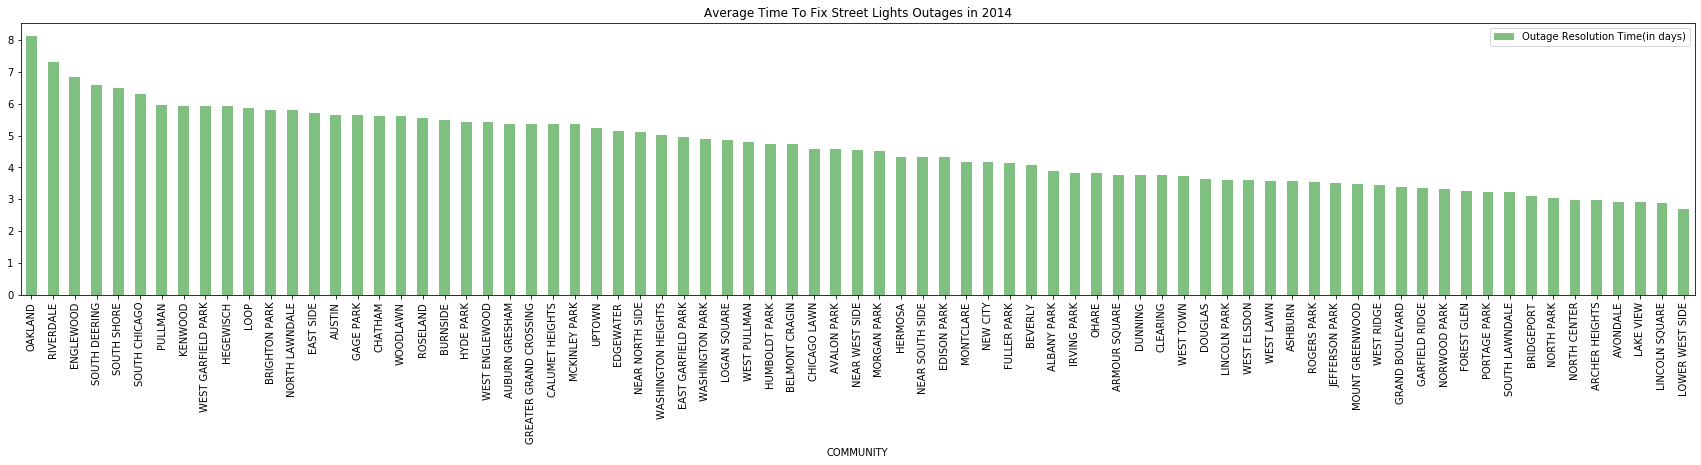

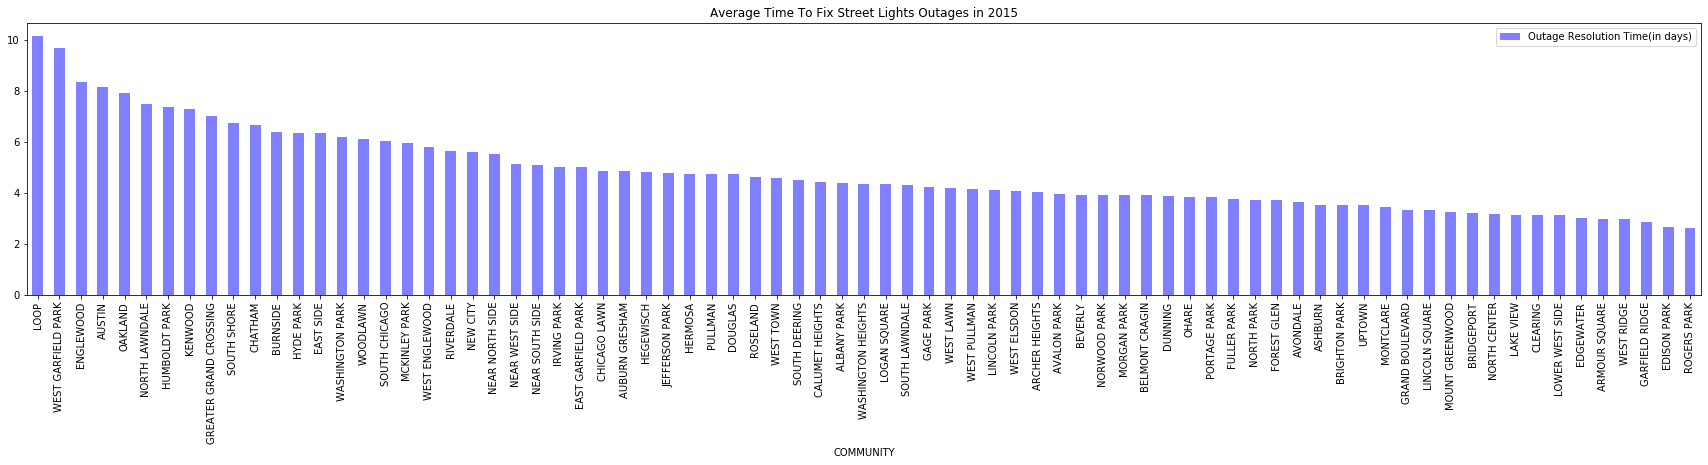

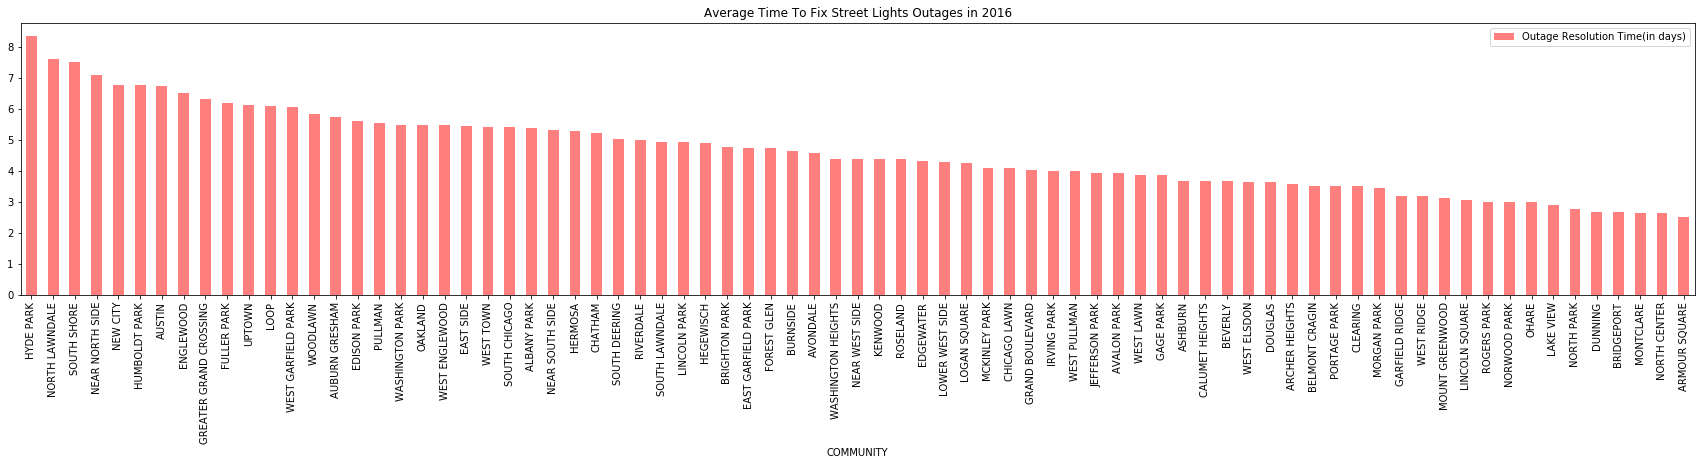

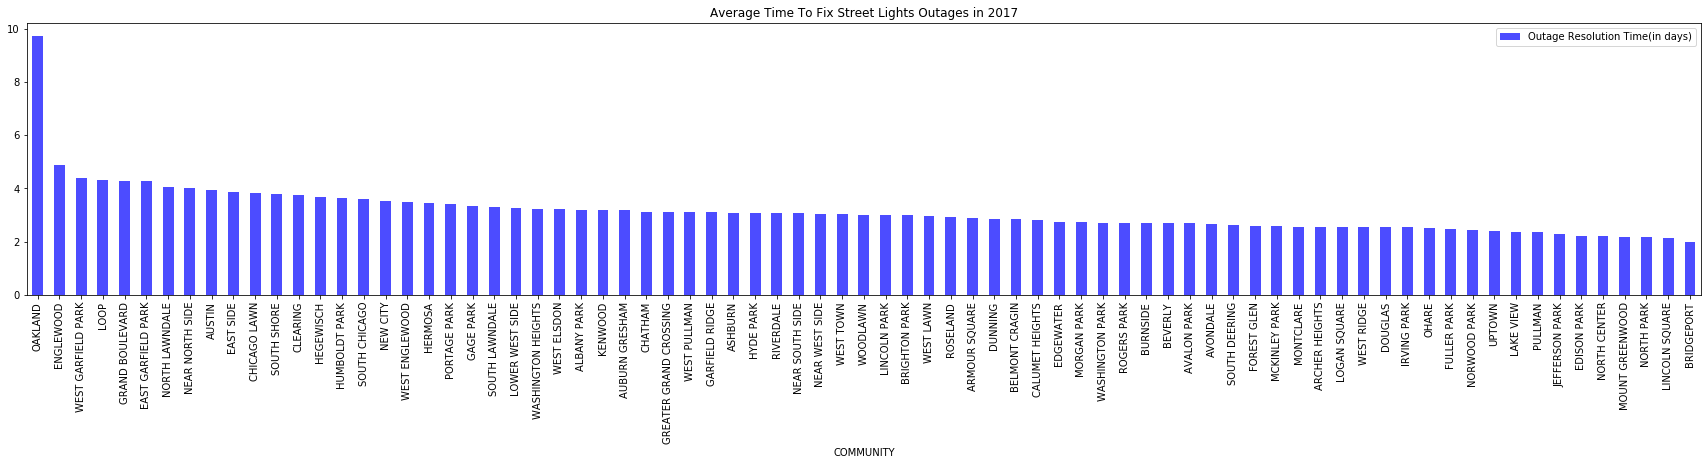

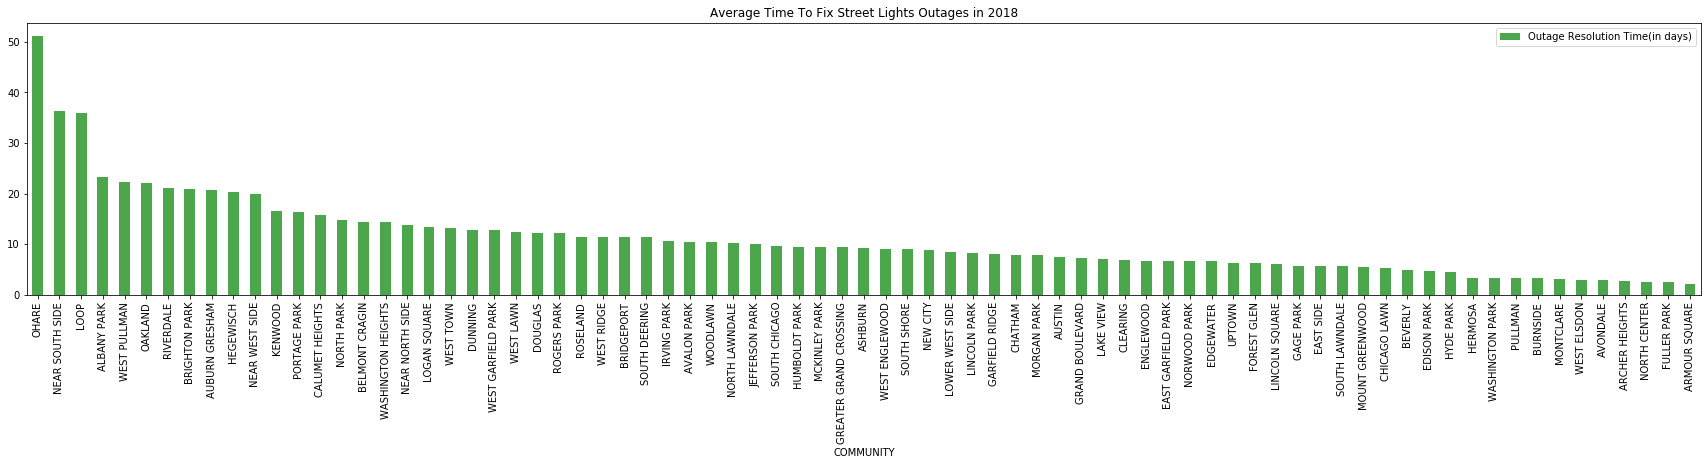

In [47]:
average_time_chart_2014 = service_requests_by_community_average_time_2014.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)",alpha=0.5, align="center", color="green", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2014")
plt.savefig("Charts/average_time_chart_2014.png", bbox_inches = 'tight')
average_time_chart_2015 = service_requests_by_community_average_time_2015.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2015")
plt.savefig("Charts/average_time_chart_2015.png", bbox_inches = 'tight')
average_time_chart_2016 = service_requests_by_community_average_time_2016.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.5, align="center", color="red", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2016")
plt.savefig("Charts/average_time_chart_2016.png", bbox_inches = 'tight')
average_time_chart_2017 = service_requests_by_community_average_time_2017.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="blue", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2017")
plt.savefig("Charts/average_time_chart_2017.png", bbox_inches = 'tight')
average_time_chart_2018 = service_requests_by_community_average_time_2018.plot.bar(y='Resolution Time(days)', x='COMMUNITY', label="Outage Resolution Time(in days)", alpha=0.7, align="center", color="green", rot=90, figsize=(30,5), title="Average Time To Fix Street Lights Outages in 2018")
plt.savefig("Charts/average_time_chart_2018.png", bbox_inches = 'tight')

## Question 4 - What are the crime rates/reports in neighborhoods with street light outages?

CRIME ANALYTICS

In [48]:
#total number of records by Community Area
c_bycomm=crime_comm.groupby(['COMMUNITY'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)
# c_bycomm=c_bycomm.sort_values(by='ID',ascending=False)

#total number of records by Year
c_byyear=crime_comm.groupby(['Year'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of records by year by Month
c_byyear_bymonth=crime_comm.groupby(['Year','Month'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crimes by crime type
c_bytype=crime_comm.groupby(['Primary Type'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crime reports by community area by year by month
c_bycomm_byyear=crime_comm.groupby(['COMMUNITY','Year'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

#total number of crime reports by community area by year by month
c_bycomm_byyear_bymonth=crime_comm.groupby(['COMMUNITY','Year','Month'])['ID'].count().reset_index().sort_values(by='ID',ascending=False)

c_bycomm_byType=crime_comm.groupby(['COMMUNITY','Primary Type'])['ID'].count().reset_index()
c_bycomm_byType=c_bycomm_byType.loc[c_bycomm_byType['COMMUNITY']=='AUSTIN']
c_bycomm_byType=c_bycomm_byType.sort_values(by='ID',ascending=False).head(5)

In [49]:
c_bycomm

,COMMUNITY,ID
5,AUSTIN,83489
47,NEAR NORTH SIDE,54023
41,LOOP,45408
52,NORTH LAWNDALE,44426
65,SOUTH SHORE,43966
...,...,...
30,HEGEWISCH,3023
44,MONTCLARE,2996
24,FOREST GLEN,2528
12,BURNSIDE,1950


In [50]:
c_byyear

,Year,ID
0,2014,275430
2,2016,269258
3,2017,268459
4,2018,267110
1,2015,264304


In [51]:
c_byyear_bymonth.head()

,Year,Month,ID
6,2014,7,26547
7,2014,8,25876
5,2014,6,25429
55,2018,8,25352
54,2018,7,25183


In [52]:
c_bytype.head()

,Primary Type,ID
31,THEFT,309972
2,BATTERY,247584
6,CRIMINAL DAMAGE,144260
1,ASSAULT,92349
17,NARCOTICS,91439


In [53]:
c_bycomm_byType.head(5)

,COMMUNITY,Primary Type,ID
142,AUSTIN,BATTERY,17613
157,AUSTIN,NARCOTICS,12125
170,AUSTIN,THEFT,11441
146,AUSTIN,CRIMINAL DAMAGE,7867
141,AUSTIN,ASSAULT,5902


311-STREET REQUEST ANALYTICS

In [55]:
#Total number of requests by community area
s_bycomm=street_comm.groupby(['COMMUNITY'])['Service Request Number'].count().reset_index()
s_bycomm.head()

#Total number of requests by year
s_byyear=street_comm.groupby(['Year'])['Service Request Number'].count().reset_index()

#Total number of requests by year by month
s_byyear_bymonth=street_comm.groupby(['Year','Month'])['Service Request Number'].count().reset_index()

#Total number of requests by community area by year
s_bycomm_byyear=street_comm.groupby(['COMMUNITY','Year'])['Service Request Number'].count().reset_index()

MERGING CRIME & 311 - STREET LIGHT OUTAGES & POPULATION DATA

In [56]:
bycomm = pd.merge(c_bycomm, s_bycomm, on="COMMUNITY", how="left")
bycomm_pop = pd.merge(bycomm, pop, left_on="COMMUNITY", right_on='Community', how="left")


CLEANING & CREATING A NEW COLUMN IN THE MERGED DATA

In [57]:
bycomm_pop['Total Population']=pd.to_numeric(bycomm_pop['Total Population'].astype(str).str.replace(',',''), errors='coerce')
bycomm_pop['No. of Service Requests to Crime Reports']=bycomm_pop['ID']/bycomm_pop['Service Request Number']


MERGED DATA ANALYTICS

In [58]:
#sorting by the ratio of Service Requests to Crime reports
bycomm_pop=bycomm_pop.sort_values(['No. of Service Requests to Crime Reports'],ascending=False)

byyear = pd.merge(c_byyear, s_byyear, on="Year", how="left")

byyearbymonth = pd.merge(c_byyear_bymonth, s_byyear_bymonth, on=["Year","Month"], how="left")

bycommbyyear = pd.merge(c_bycomm_byyear, s_bycomm_byyear, on=["COMMUNITY","Year"], how="left")
bycommbyyear = pd.merge(bycommbyyear, comm, on=["COMMUNITY"], how="left")

In [59]:
bycomm_pop
# Notes:
# Forest Glen (1:3.73)
# Austin (1:31)
# Loop (1:57)

,COMMUNITY,ID,Service Request Number,Community,Community Area,Total Population,Age 0-2 (Population),Age 3-4 (Population),Age 5 (Population),Age 6-12 (Population),Age 13+ (Population),No. of Service Requests to Crime Reports
2,LOOP,45408,797,LOOP,32.0,32936.0,"1,051",629,260,"1,516","29,480",56.973651
48,OHARE,8907,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.784884
25,ROGERS PARK,19037,407,ROGERS PARK,1.0,53470.0,"2,164","1,166",616,"3,819","45,705",46.773956
1,NEAR NORTH SIDE,54023,1232,NEAR NORTH SIDE,8.0,96466.0,"2,902","1,445",467,"3,092","88,560",43.849838
15,WEST GARFIELD PARK,29120,798,WEST GARFIELD PARK,26.0,20146.0,"1,198","1,068",320,"2,273","15,287",36.491228
...,...,...,...,...,...,...,...,...,...,...,...,...
72,HEGEWISCH,3023,603,HEGEWISCH,55.0,9745.0,483,225,115,961,"7,961",5.013267
76,EDISON PARK,1338,283,EDISON PARK,9.0,10856.0,201,226,38,"1,086","9,305",4.727915
71,MOUNT GREENWOOD,3057,718,MOUNT GREENWOOD,74.0,16878.0,773,574,297,"1,452","13,782",4.257660
66,BEVERLY,4705,1242,BEVERLY,72.0,19969.0,827,582,229,"1,695","16,636",3.788245


LET'S MAKE SOME VISUALS


2528
677


Text(2528, 677, 'FOREST GLEN (Smallest  Service Request to Crime Report Ratio)')

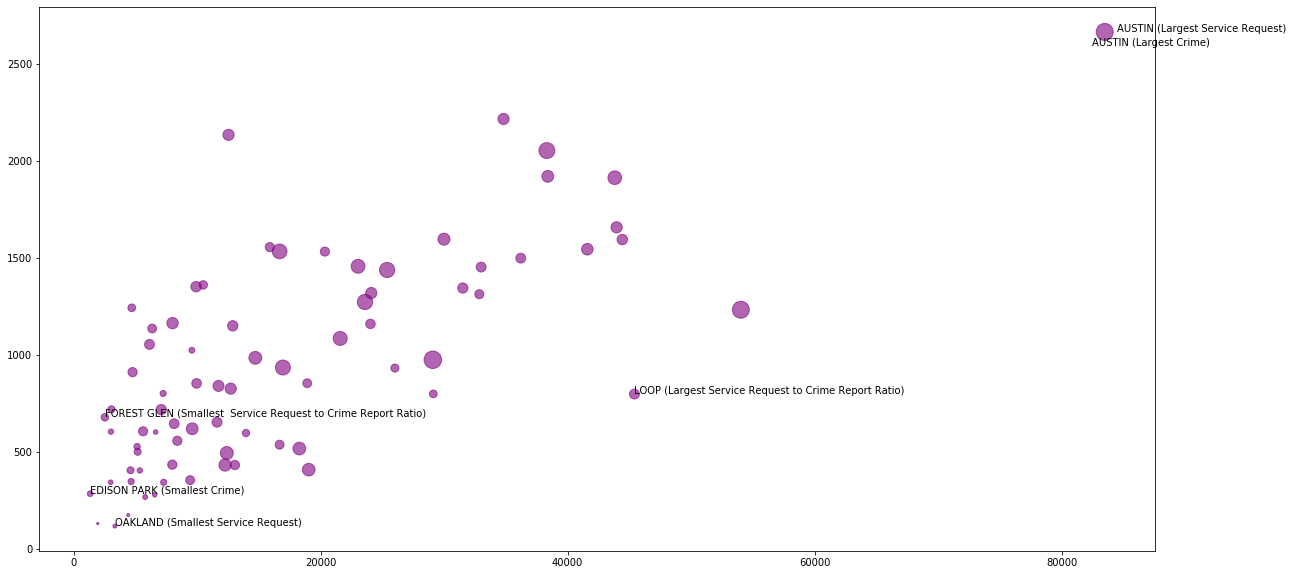

In [60]:
#community areas by crime by street

x=bycomm_pop['ID']
y=bycomm_pop['Service Request Number']
z=bycomm_pop['Community']
w=bycomm_pop['No. of Service Requests to Crime Reports']

fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x,y,s=bycomm_pop['Total Population']*.003,c='purple',alpha=0.6)

#Street light request data
y_max=y.max()
y_min=y.min()

i=bycomm_pop.loc[y==y_max, 'ID'].iloc[0]
j=bycomm_pop.loc[y==y_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[y==y_max, 'Community'].iloc[0] + " (Largest Service Request)", xy=(i+1000, j))

k=bycomm_pop.loc[y==y_min, 'ID'].iloc[0]
m=bycomm_pop.loc[y==y_min, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[y==y_min, 'Community'].iloc[0] + " (Smallest Service Request)", xy=(k, m))

#Crime numbers
x_max=x.max()
x_min=x.min()

n=bycomm_pop.loc[x==x_max, 'ID'].iloc[0]
p=bycomm_pop.loc[x==x_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[x==x_max, 'Community'].iloc[0] + " (Largest Crime)", xy=(n-1000, p-75))

q=bycomm_pop.loc[x==x_min, 'ID'].iloc[0]
r=bycomm_pop.loc[x==x_min, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[x==x_min, 'Community'].iloc[0] + " (Smallest Crime)", xy=(q, r))

#Service Request to Crime ratio
w_max=w.max()
w_min=w.min()

t=bycomm_pop.loc[w==w_max, 'ID'].iloc[0]
u=bycomm_pop.loc[w==w_max, 'Service Request Number'].iloc[0]
ax.annotate(bycomm_pop.loc[w==w_max, 'Community'].iloc[0] + " (Largest Service Request to Crime Report Ratio)", xy=(t, u))

a=bycomm_pop.loc[w==w_min, 'ID'].iloc[0]
b=bycomm_pop.loc[w==w_min, 'Service Request Number'].iloc[0]
print(a)
print(b)
ax.annotate(bycomm_pop.loc[w==w_min, 'Community'].iloc[0] + " (Smallest  Service Request to Crime Report Ratio)", xy=(a, b))

In [61]:
#https://www.kaggle.com/threadid/geopandas-mapping-chicago-crimes 

street_map= gpd.read_file(r'C:\Users\dharti.patel\Desktop\NU_DS_Project1\Street-Lights\Street-Lights\geo_export_f11eb402-3887-43c2-a681-95fde0bf6fbf.shp')

# fig,ax=plt.subplots(figsize=(15,15))
# street_map.plot(ax=ax)

[Text(0.5, 1, 'Street Light Outages 2018')]

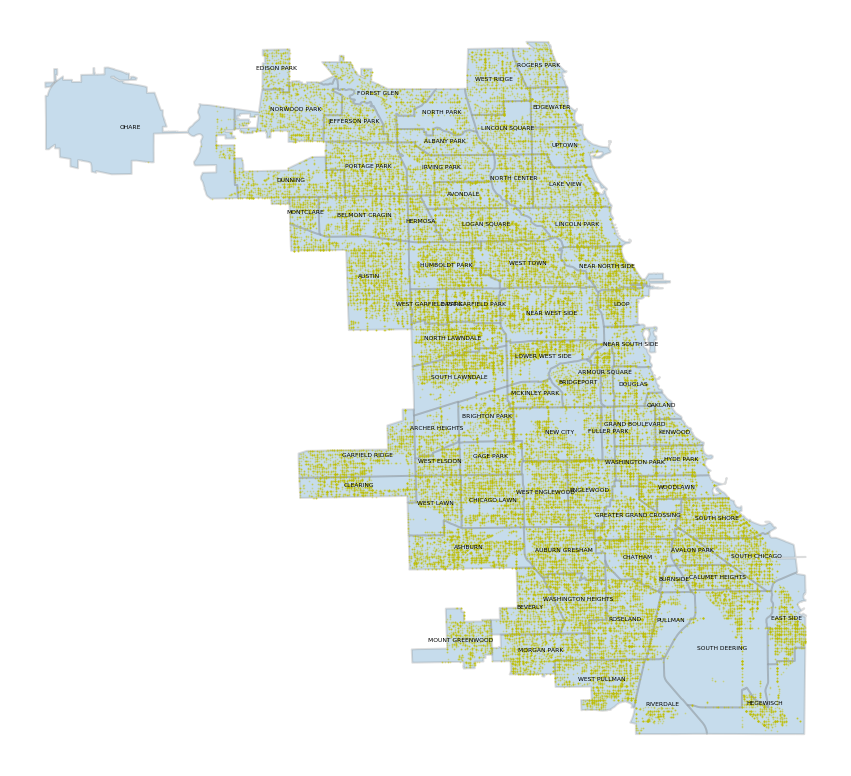

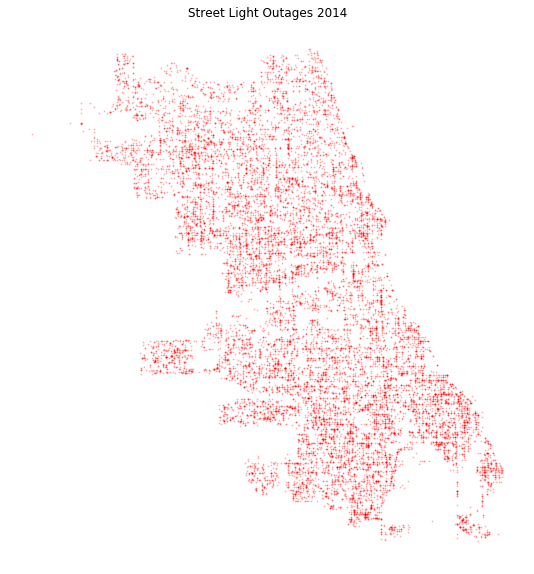

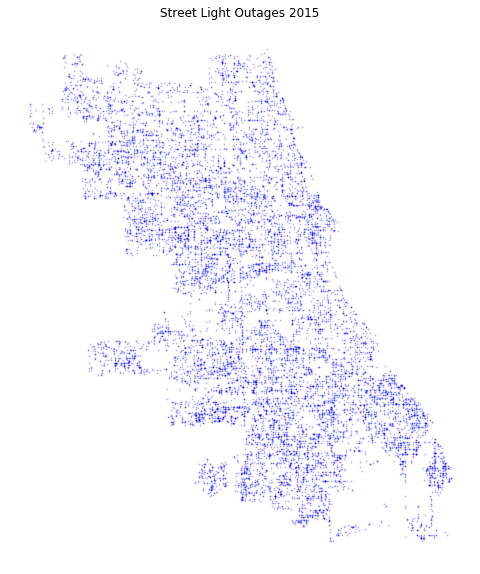

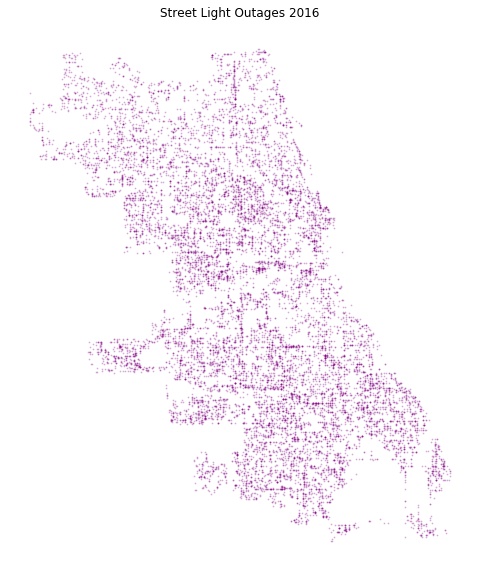

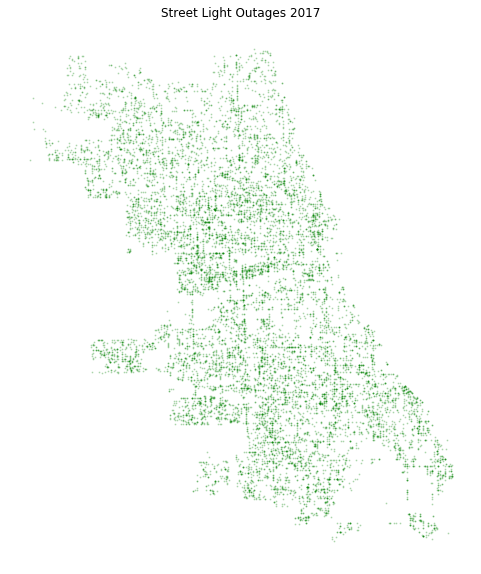

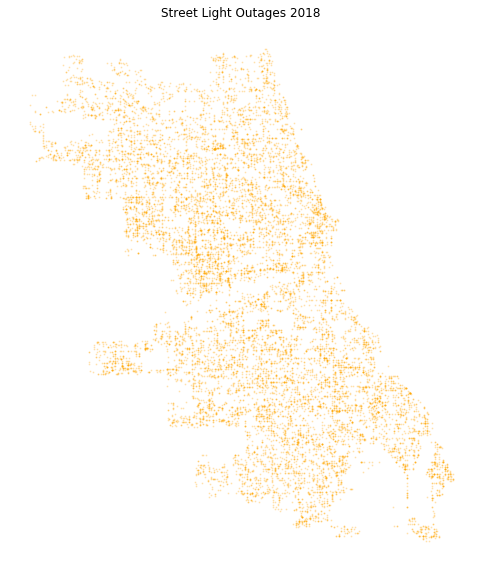

In [62]:
#Street Lights

crs={'init':'epsg:4326'}
street_comm.dtypes
street_comm.head()

geometry= [Point(xy) for xy in zip(street_comm["Longitude"],street_comm["Latitude"])]
geometry[:3]


geo_df=gpd.GeoDataFrame(street_comm,
                       crs=crs,
                       geometry=geometry)
geo_df.head()

# fig.ax=plt.subplots(figsize=(15,15))
# street_map.plot(ax=ax,alpha=0.4,color="grey")
# geo_df[geo_df[geometry]==0].plot(ax=ax,markersize=20,color="blue",marker="o",label="Neg")
# # geo_df[geo_df['WnvPresent']==0].plot(ax=ax,markersize=20,color="red",marker="^",label="Pos")
# # plt.legend(plot={'size':15})

street_loc_df = geo_df.dropna(inplace=False)  # Remove all nan entries. 
street_loc_df = street_loc_df.drop(street_loc_df[(street_loc_df.Latitude < 41.0)].index) #Remove bad values in Long/Lat 
street_loc_df['AREA_NUMBE'] = street_loc_df['AREA_NUMBE'].astype(int)
street_geometry = [Point(xy) for xy in zip(street_loc_df.Longitude, street_loc_df.Latitude)]
# street_geometry = geo_df['geometry']

street_crs = {'type': 'EPSG', 'properties': {'code': 102671}}
street_points = GeoDataFrame(street_loc_df, crs=street_crs, geometry=street_geometry)
street_points.head(5)

# street_map = geo_df.plot(figsize=(25,25), edgecolor='k', facecolor='b', alpha=0.25, linewidth=2) 

#Street lights data
# street_points = street_points.plot(figsize=(10,10), markersize=5) 
# street_points.set_axis_off()

# chistreet_map = street_map.plot(figsize=(25,25), edgecolor='#7f7f7f', cmap='nipy_spectral', alpha=0.5, linewidth=2) 
# street_map.apply(lambda x: chistreet_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=16),axis=1);
# chistreet_map.set_axis_off()

chistreet_map = street_map.plot(figsize=(15,15), edgecolor='#7f7f7f', facecolor='#1f77b4', alpha=0.25, linewidth=2) 
street_map.apply(lambda x: chistreet_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=6),axis=1);
street_points.plot(figsize=(25,25),ax=chistreet_map, markersize=1, color='y', alpha=0.25)
chistreet_map.set_axis_off()

#yearly streetlight visual

# for i in (2014,2015,2016,2017,2018):
#     street_vc_points = street_points.loc[street_points['Year'].isin([i])]

#     street_vc_points_map = street_vc_points.plot(figsize=(5,5), markersize=1, c='blue', alpha=0.2) 
#     street_vc_points_map.set_axis_off()
#     street_vc_points_map.set(title=i)
    
#yearly streetlight visual

street_vc_points = street_points.loc[street_points['Year'].isin(['2014'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='red', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2014')

street_vc_points = street_points.loc[street_points['Year'].isin(['2015'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='blue', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2015')

street_vc_points = street_points.loc[street_points['Year'].isin(['2016'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='purple', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2016')

street_vc_points = street_points.loc[street_points['Year'].isin(['2017'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='green', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2017')

street_vc_points = street_points.loc[street_points['Year'].isin(['2018'])]

street_vc_points_map = street_vc_points.plot(figsize=(10,10), markersize=1, c='orange', alpha=0.2) 
street_vc_points_map.set_axis_off()
street_vc_points_map.set(title='Street Light Outages 2018')



[Text(0.5, 1, 'Crime: Battery (2018)')]

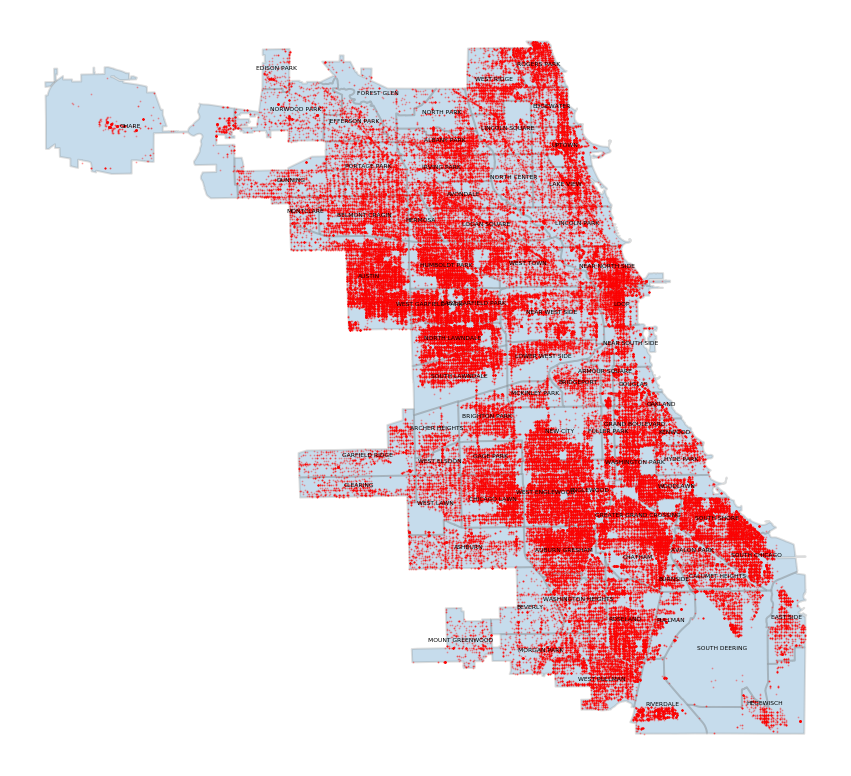

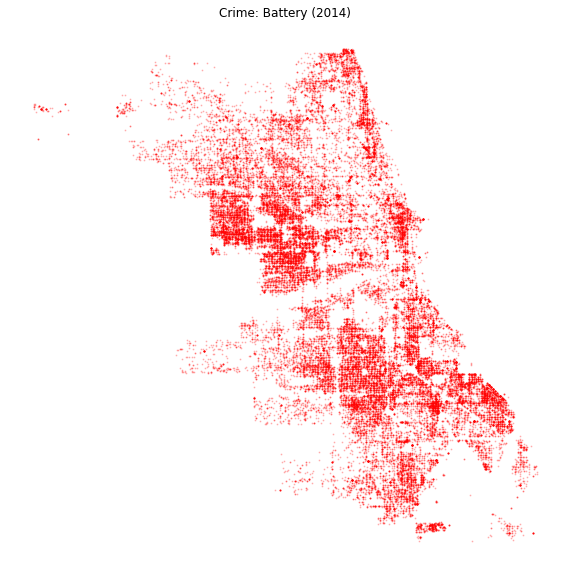

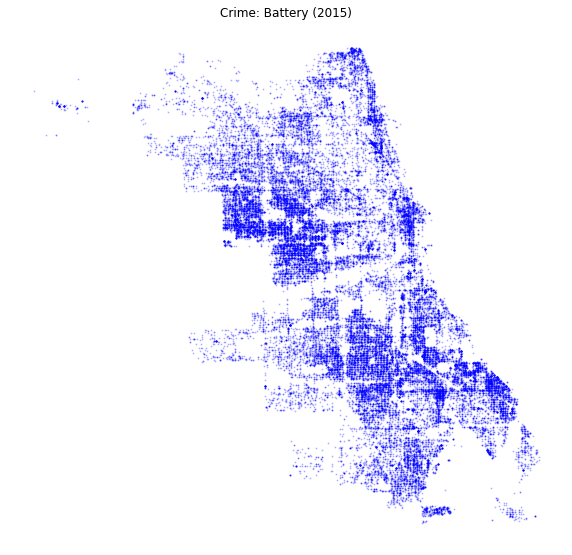

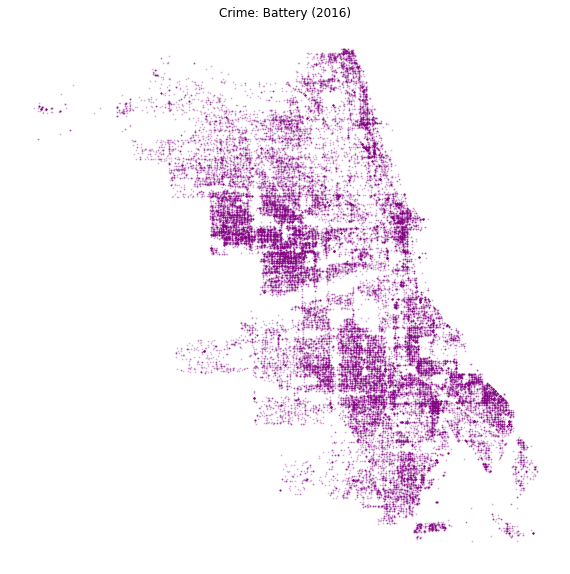

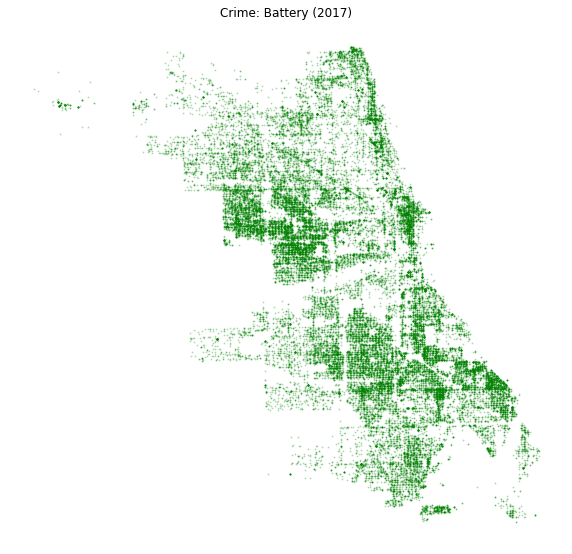

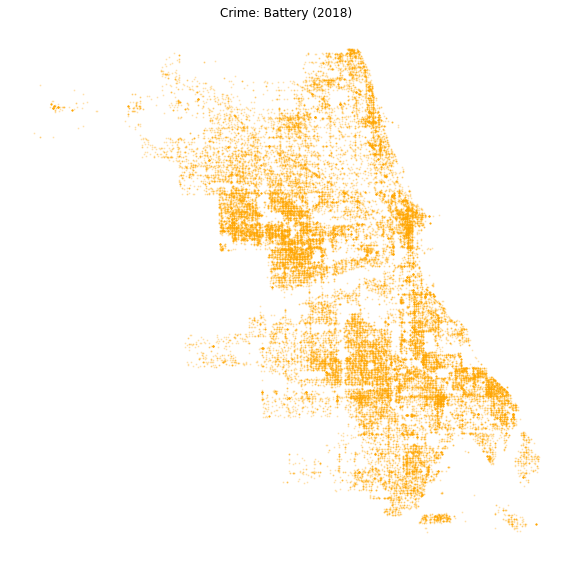

In [63]:
# Crime maps

crime_comm['Primary Type'].unique()

crime_comm_type=crime_comm.loc[crime_comm['Primary Type']=='BATTERY']




crs={'init':'epsg:4326'}
crime_comm_type.dtypes
crime_comm_type.head()

geometry= [Point(xy) for xy in zip(crime_comm_type["Longitude"],crime_comm_type["Latitude"])]
geometry[:3]


geo_df=gpd.GeoDataFrame(crime_comm_type,
                       crs=crs,
                       geometry=geometry)
geo_df.head()

# fig.ax=plt.subplots(figsize=(15,15))
# crime_map.plot(ax=ax,alpha=0.4,color="grey")
# geo_df[geo_df[geometry]==0].plot(ax=ax,markersize=20,color="blue",marker="o",label="Neg")
# # geo_df[geo_df['WnvPresent']==0].plot(ax=ax,markersize=20,color="red",marker="^",label="Pos")
# # plt.legend(plot={'size':15})

crime_loc_df = geo_df.dropna(inplace=False)  # Remove all nan entries. 
crime_loc_df = crime_loc_df.drop(crime_loc_df[(crime_loc_df.Latitude < 41.0)].index) #Remove bad values in Long/Lat 
crime_loc_df['AREA_NUMBE'] = crime_loc_df['AREA_NUMBE'].astype(int)
crime_geometry = [Point(xy) for xy in zip(crime_loc_df.Longitude, crime_loc_df.Latitude)]
# crime_geometry = geo_df['geometry']

crime_crs = {'type': 'EPSG', 'properties': {'code': 102671}}
crime_points = GeoDataFrame(crime_loc_df, crs=crime_crs, geometry=crime_geometry)
crime_points.head(5)

# crime_map = geo_df.plot(figsize=(25,25), edgecolor='k', facecolor='b', alpha=0.25, linewidth=2) 

#crime lights data
# crime_points = crime_points.plot(figsize=(10,10), markersize=5) 
# crime_points.set_axis_off()

# chicrime_map = crime_map.plot(figsize=(25,25), edgecolor='#7f7f7f', cmap='nipy_spectral', alpha=0.5, linewidth=2) 
# crime_map.apply(lambda x: chicrime_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=16),axis=1);
# chicrime_map.set_axis_off()

chicrime_map = street_map.plot(figsize=(15,15), edgecolor='#7f7f7f', facecolor='#1f77b4', alpha=0.25, linewidth=2) 
street_map.apply(lambda x: chicrime_map.annotate(s=x.community, xy=x.geometry.centroid.coords[0], ha='center', size=6),axis=1);
crime_points.plot(figsize=(25,25),ax=chicrime_map, markersize=1, color='r', alpha=0.25)
chicrime_map.set_axis_off()

#yearly streetlight visual

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2014'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='red', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2014)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2015'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='blue', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2015)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2016'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='purple', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2016)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2017'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='green', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2017)')

crime_vc_points = crime_points.loc[crime_points['Year'].isin(['2018'])]

crime_vc_points_map = crime_vc_points.plot(figsize=(10,10), markersize=1, c='orange', alpha=0.2) 
crime_vc_points_map.set_axis_off()
crime_vc_points_map.set(title='Crime: Battery (2018)')